# Calculating Peak Ground Accelarations ($PGA_{\Delta A}$) using mean field crustal attenuation ($\Delta$) and local site-specific amplification ($A$)

This notebook provides step-by-step procedure to incorporate methodology described in Agrawal & McCloskey 2024

Contents of this notebook:
<ol>
    <li><a href=#domain />Loading the domain characteristics, receiver locations and hypocentral coordinates</a></li>
    <li><a href=#pga />Loading PGA values resulting out of physics-based simulations ($PGA_{true}$)</a></li>
    <li><a href=#pgada />Calculating $PGA_{\Delta A}$ </a></li>
       <ol>
        <li><a href=#ev />Choose event </a> </li>
        <li><a href=#delta />Calculating $\Delta$ </a></li>
        <li><a href=#aj />Calculating $A$ </a></li>
        <li><a href=#calsim />Calculate $PGA_{\Delta A}$ versus $PGA_{true}$ </a></li>
        
 </ol>
     <li><a href=#easyload />Plot for all 40 events</a></li>
    
</ol>




In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
from shapely.geometry import Point, Polygon
from scipy.stats import gmean
from scipy.optimize import curve_fit
from matplotlib import ticker
from matplotlib.ticker import FormatStrFormatter
import geopandas
import matplotlib.patches as patches
from matplotlib.cm import ScalarMappable
from matplotlib.gridspec import GridSpec


<a name='domain' /></a>
### 1. Loading crustal domain characteristics (basin geometries), receiver locations and hypocentral coordinates

Notes:
1. The simulations are recorded at 19994 locations on the surface of crustal domain (`LS.input`), out of which, Tomorrowville (TV) domain contains first 10000 receivers (`LS_inTVdomain.input`), arranged in 100X100 grid.
2. For earthquake sources, we only need hypocentral locations which are provided for all 40 events in `hypo_all.txt` file
3. Earthquake ruptures have following distribution across the crustal domain:

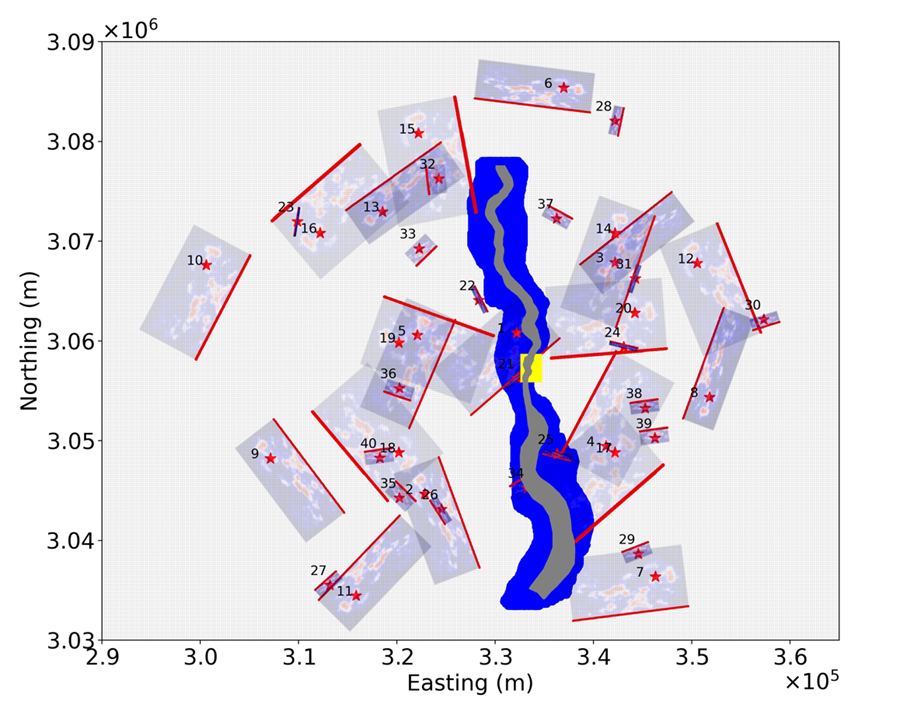

In [19]:

## Basin files
basin='Data/basin_geometry/'
mb_file='Surface_3D_MainBasin.txt'
rb_file='Surface_3D_RiverChannel.txt'
mb_df=pd.read_csv(basin+mb_file,names=["x","y","z"],delim_whitespace=True)
rb_df=pd.read_csv(basin+rb_file,names=["x","y","z"],delim_whitespace=True)
mb_bound=np.load(basin+'main_basin_bound.npy')
rb_bound=np.load(basin+'river_basin_bound.npy')


## Receivers in TV_domain
LS_tv='Data/receivers/LS_inTVdomain.input'
file=open(LS_tv,'r')
s=file.readlines()
moni_tv=np.zeros((len(s)-1,4))
i=0
for f in s:
    if i!=0:
        moni_tv[i-1]=(np.float_(np.array(f.split())))
    i+=1

x1tv=np.min(moni_tv[:,1])
x2tv=np.max(moni_tv[:,1])
y1tv=np.min(moni_tv[:,2])
y2tv=np.max(moni_tv[:,2])


## Hypocenter
hypofile='Data/hypo_all.txt'
hypo_all=pd.read_csv(hypofile, names=["x", "y", "z"], delim_whitespace=True)

## All receivers on the surface on curstal domain
locf_file="Data/receivers/LS.input"
df_locations = pd.read_csv(locf_file, skiprows=1, names=["nodeID", "x", "y", "z"], delim_whitespace=True)


 <a name='pga' /></a>

### 2. Loading PGA values resulting out of simulations ($PGA_{true}$)

In [3]:
nev=40 #total_number of events

pgaz_all=np.zeros((nev,100,100)) #setting up an array to store all the pga values
for i in range(nev):
    IMFilename_nc='Data/nc_PGA/sim_IM'+str(i)+'.nc'
    df_tmp=xr.open_dataset(IMFilename_nc)
    df_tmp.close()
    df=df_tmp.to_dataframe()
    pgaz=np.array(df.pgaz[:10000]).reshape(100,100) #loading vertical (z) component values for this demonstration 
    pgaz_all[i]=np.flipud(np.transpose(pgaz))
 

In [16]:
df.head()

,x,y,z,pgax,pgay,pgaz
index,,,,,,
0,332635.0,3055871.0,0.0,0.218892,0.272823,0.216998
1,332635.0,3055899.0,0.0,0.227732,0.263190,0.224239
2,332635.0,3055927.0,0.0,0.234033,0.250721,0.228449
3,332635.0,3055955.0,0.0,0.237656,0.243168,0.229890
4,332635.0,3055983.0,0.0,0.239708,0.241711,0.229268


<a href=#iii /> </a>

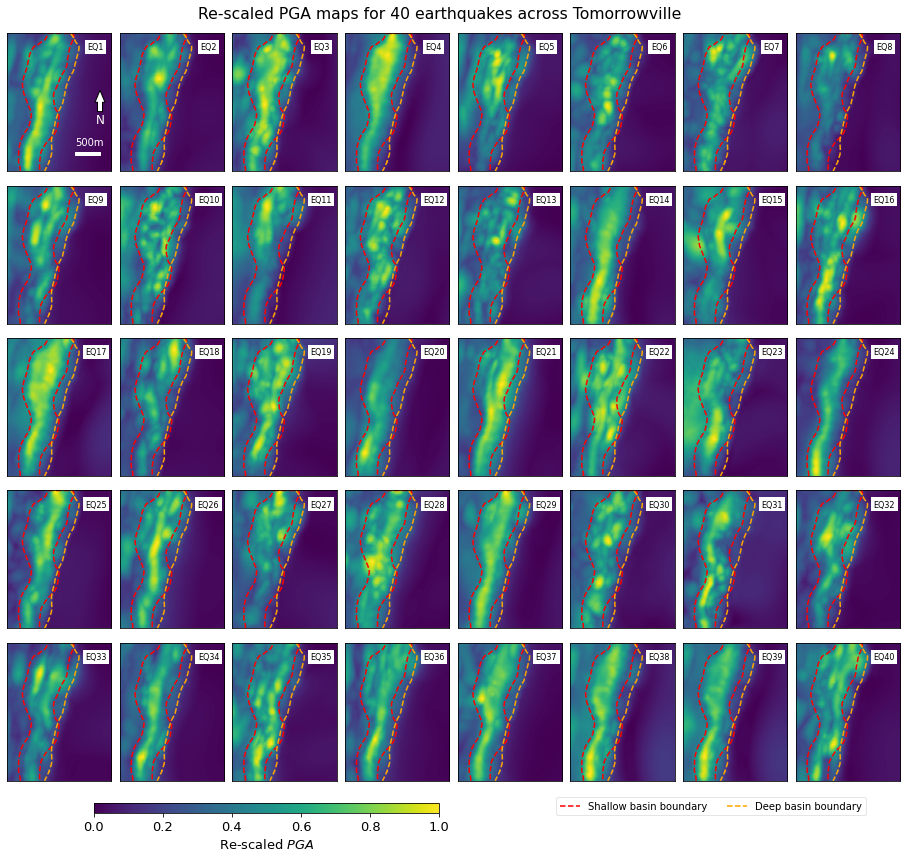

In [7]:
fig, axes = plt.subplots(5, 8, figsize=(16, 14),sharex=True,sharey=True)
plt.rc('font',size=13)

# Loop through each subplot
for i, ax in enumerate(axes.flat):
    extent=(np.min(df.x[:10000]),np.max(df.x[:10000]),np.min(df.y[:10000]),np.max(df.y[:10000]))
    ax.imshow((pgaz_all[i]-np.min(pgaz_all[i]))/(np.max(pgaz_all[i]-np.min(pgaz_all[i]))),extent=extent,aspect=1.00)
    ax.plot(rb_bound[0],rb_bound[1],color='red',label='Shallow basin boundary',linestyle='dashed')
    ax.plot(mb_bound[0],mb_bound[1],color='orange',label='Deep basin boundary',linestyle='dashed')
    scale_length = 200  
    scale_x = 0.85  
    scale_y = 0.9  
    ax.annotate(f'EQ{i+1}', (scale_x, scale_y), xycoords='axes fraction',
                ha='center', va='center', fontsize=8,
                bbox=dict(boxstyle='square', fc='white',ec='None'))  # Add the scale annotation
    ax.xaxis.set_tick_params(labelbottom=False)
    ax.yaxis.set_tick_params(labelleft=False)
    ax.set_xticks([])
    ax.set_yticks([])
    if i==0:
        rect = patches.Rectangle((334000, 3056200), 500, 50, linewidth=1, edgecolor='white', facecolor='white')
        ax.add_patch(rect)
        ax.text(334000,3056400,'500m',c='white',fontsize=10)
        x,y=334500, 3057500
        arrow_length=600
        ax.annotate('N',color='white', xy=(x,y ), xytext=(x, y-arrow_length),
                    arrowprops=dict(facecolor='white', width=5, headwidth=10),
                    ha='center', va='center', fontsize=12)
        

plt.subplots_adjust(hspace=0.005,wspace=0.08)
ax.legend(fontsize='10',framealpha=0.5,loc=[-2.3,-0.25],ncol=2)
plt.suptitle(t='Re-scaled PGA maps for 40 earthquakes across Tomorrowville',x=0.5,y=0.9)
sm = plt.cm.ScalarMappable(cmap='viridis')
colorbar_extent = [0.2, 0.1, 0.3, 0.01] 
cax = fig.add_axes(colorbar_extent)
cbar = plt.colorbar(sm, cax=cax, orientation='horizontal')
cbar.set_label(r'Re-scaled $PGA$')
plt.show()

<a name='pgada' /> </a>
## 3.  Calculating $PGA_{\Delta A}$ for one event
<a name='ev' /> </a>
#### A. Choose event 

In [4]:
event_index=12 #Index of the earthquake chosen for this demonstration
nev=40 #Total number of earthquakes

<a name='delta' /></a>
#### B. Calculate $\Delta$

Text(0, 0.5, 'Northing (m)')

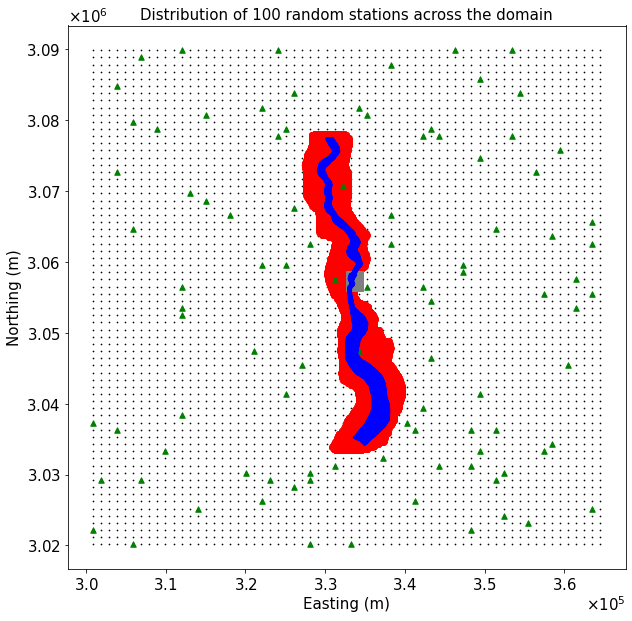

In [5]:
## subsetting a subset domain from the entire 100X100 extent to add padding around the edges
####This is done to make sure receivers stay within reasonable distance from Tomorrowville.
x1md=300000.0
x2md=365000.0
y1md=3020000.0
y2md=3090000.0
#############################################
seed=100 ##random seed
set_size=100 ##number of receivers used to sample the surface of the crustal domain
#########################################

md_coord=[[x1md,y1md],[x2md,y1md],[x2md,y2md],[x1md,y2md]]
md_polygon=Polygon(md_coord)
md_coord.append(md_coord[0])
md_arr=np.array(md_coord)
mask_x=df_locations[10000:].x.between(x1md,x2md)
mask_xy=df_locations[10000:][mask_x].y.between(y1md,y2md)
df_md=df_locations[10000:][mask_x][mask_xy]


total_points=len(df_md)

np.random.seed(seed)
random_set=np.random.randint(total_points,size=[set_size])
random_moni=pd.DataFrame({"nodeID":[], "x":[], "y":[], "z":[]})

for i in random_set:
    random_moni = pd.concat([random_moni, df_md[i:i+1]], ignore_index=True)
    
fig=plt.figure(figsize=(10,10))
plt.rc('font',size=15)
plt.ticklabel_format(useMathText=True)
plt.scatter(df_md.x,df_md.y,c='black',s=0.5)
plt.ticklabel_format(useMathText=True,style='sci', scilimits=(0,0))
plt.scatter(mb_df.x,mb_df.y,c='red')
plt.plot(rb_df.x[rb_df.z==0],rb_df.y[rb_df.z==0],c='blue')
tv_rectangle=plt.Rectangle((x1tv,y1tv),(x2tv-x1tv),(y2tv-y1tv),fc='gray',ec='gray')
plt.gca().add_patch(tv_rectangle)
plt.scatter(random_moni.x,random_moni.y,c='green',s=30.0,marker="^")
plt.title('Distribution of 100 random stations across the domain',fontsize=15)
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')


In [7]:
df_random=pd.DataFrame({ "x":[], "y":[], "z":[],"pgax":[],"pgay":[],"pgaz":[],"R":[]})
random_indices=np.array((random_moni['nodeID']-1))
k=0
for i in range(nev):
    if i!= event_index:
        IMFilename_nc='Data/nc_PGA/sim_IM'+str(i)+'.nc'
        df_tmp=xr.open_dataset(IMFilename_nc)
        df_tmp.close()
        df=df_tmp.to_dataframe()
        df_random=pd.concat([df_random,df.iloc[random_indices]])
        dist=[np.linalg.norm(np.array(df.iloc[random_indices][['x','y']])[j]-np.array(hypo_all[['x','y']])[i]) for j in range(set_size)]
        df_random['R'][set_size*k:set_size*(k+1)]=dist
        k+=1

In [8]:
if event_index<20:
    df_rd_m6=df_random[0:1900] ## subsetting dataframe for Mw6 recordings for random locations
    df_rd_m5=df_random[1900:]  ##subsetting dataframe for Mw5 recordings for random locations
else:
    df_rd_m6=df_random[0:2000] ## subsetting dataframe for Mw6 recordings for random locations
    df_rd_m5=df_random[2000:]  ##subsetting dataframe for Mw5 recordings for random locations

In [9]:
### Regression fitting the PGA values at 100 random locations for Mw6 and Mw5 separately
def gmpe(r,a,b,c):
    return a/(r+b)**c

sort_i=df_rd_m6.R.argsort()
xdata_sort_m6=df_rd_m6.R.iloc[sort_i]
ydata_sort_m6=df_rd_m6.pgaz.iloc[sort_i]
popt_m6,pcov_m6 = curve_fit(gmpe,xdata_sort_m6,ydata_sort_m6,maxfev=100000)



sort_i=df_rd_m5.R.argsort()
xdata_sort_m5=df_rd_m5.R.iloc[sort_i]
ydata_sort_m5=df_rd_m5.pgaz.iloc[sort_i]
popt_m5,pcov_m5 = curve_fit(gmpe,xdata_sort_m5,ydata_sort_m5,maxfev=100000)

Text(0.5, 0, 'Epicentral distance, R (m)')

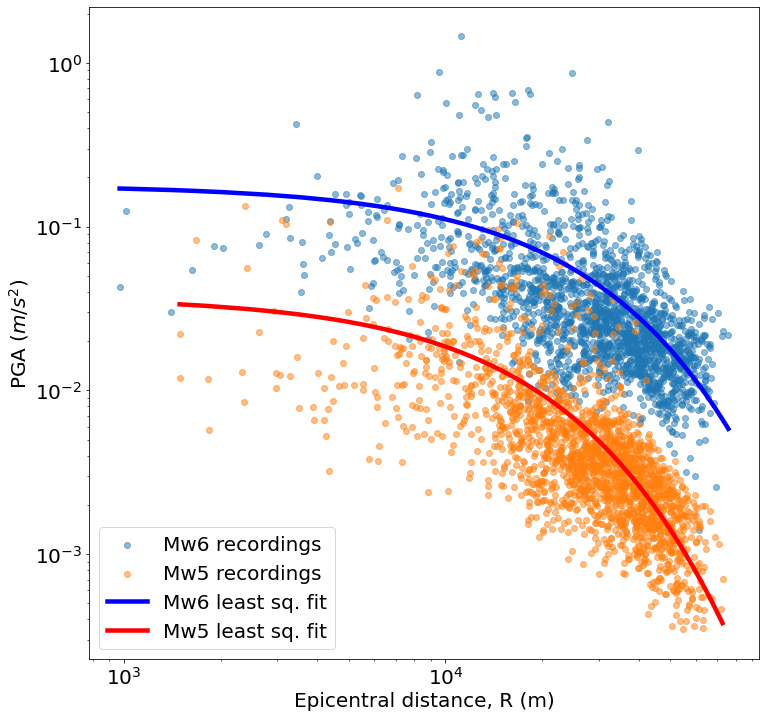

In [10]:
fig=plt.figure(figsize=(12,12))
plt.rc('font',size=20)
plt.scatter(df_rd_m6.R,df_rd_m6.pgaz,label='Mw6 recordings',alpha=0.5)
plt.scatter(df_rd_m5.R,df_rd_m5.pgaz,label='Mw5 recordings',alpha=0.5)
plt.plot(xdata_sort_m6,(gmpe(xdata_sort_m6,*popt_m6)),'b-',linewidth=4.5,label='Mw6 least sq. fit')
plt.plot(xdata_sort_m5,(gmpe(xdata_sort_m5,*popt_m5)),'r-',linewidth=4.5,label='Mw5 least sq. fit')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'PGA $(m/s^2)$')
plt.xlabel('Epicentral distance, R (m)')

<a name='aj' /></a>
#### C. Calculate $A$

[]

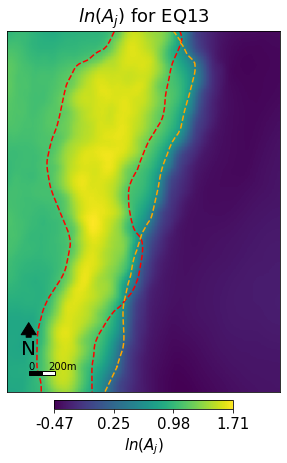

In [18]:
aj=np.zeros((nev,10000)) ##amplification kernel
var=np.zeros((nev,10000)) ##amplification kernel
amp=np.zeros((nev-1,10000)) ##amplification kernel
no=0
for j in range(nev): ##taking all other events to calculate amplificaation kernel
    if j!=event_index:
        IMFilename_nc='Data/nc_PGA/sim_IM'+str(j)+'.nc'
        df_tmp=xr.open_dataset(IMFilename_nc)
        df_tmp.close()
        df=df_tmp.to_dataframe()
        pgaz=df.pgaz[:10000]
    
        ###Normalising based on mean field attenuation
        hypo_tmp=np.zeros((10000))
        dist=np.sqrt((np.array(df.x[:10000])-(hypo_tmp+np.array(hypo_all.x)[j]))**2  +  (np.array(df.y[:10000])-(hypo_tmp+np.array(hypo_all.y)[j]))**2)
        if j<20:
            median=gmpe(dist,*popt_m6)
        else:
            median=gmpe(dist,*popt_m5)
        amp[no]=np.log(pgaz/median)
        no=no+1


aj[event_index]=np.mean(amp,axis=0)
var[event_index]=np.std(amp,axis=0)


fig,ax=plt.subplots(1,1,figsize=(8,8))
plt.rc('font',size=15)
extent=(np.min(df.x[:10000]),np.max(df.x[:10000]),np.min(df.y[:10000]),np.max(df.y[:10000]))
plt.scatter(df.x[:10000],df.y[:10000],c=aj[event_index])
aj_plot=np.flipud(np.transpose(aj[event_index].reshape(100,100)))
plt.imshow(aj_plot,extent=extent,zorder=1,aspect=1.0)
ax.set_xlim(extent[0], extent[1])
ax.set_ylim(extent[2], extent[3])
cbar=plt.colorbar(shrink=0.4,orientation='horizontal',ticks=np.linspace(np.min(aj_plot),np.max(aj_plot),4),pad=0.02)
cbar.set_label(r'$ln(A_{j})$')
cbar.ax.get_yaxis().labelpad = 20
cbar.ax.xaxis.set_major_formatter(ticker.FormatStrFormatter("%.2f"))
plt.title(r'$ln(A_{j})$ for EQ'+str(event_index+1))
plt.plot(rb_bound[0],rb_bound[1],color='red',label='Shallow basin boundary',linestyle='dashed')
plt.plot(mb_bound[0],mb_bound[1],color='orange',label='Deep basin boundary',linestyle='dashed')
#adding scale
rect = patches.Rectangle((332800, 3056000), 100, 30, linewidth=1, edgecolor='black', facecolor='black',zorder=i+2)
ax.add_patch(rect)
rect2 = patches.Rectangle((332900, 3056000), 100, 30, linewidth=1, edgecolor='black', facecolor='white',zorder=i+2)
ax.add_patch(rect2)

ax.text(332800,3056045,'0',c='black',fontsize=10)

ax.text(332950,3056045,'200m',c='black',fontsize=10)

x,y=332800, 3056400
arrow_length=200
ax.annotate('N', xy=(x,y ), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20)
# Hide X and Y axes label marks
ax.xaxis.set_tick_params(labelbottom=False)
ax.yaxis.set_tick_params(labelleft=False)

# Hide X and Y axes tick marks
ax.set_xticks([])
ax.set_yticks([])

<a name='calsim' /></a>
#### D. Calculate correlation between $PGA_{\Delta A}$ versus $PGA_{true}$

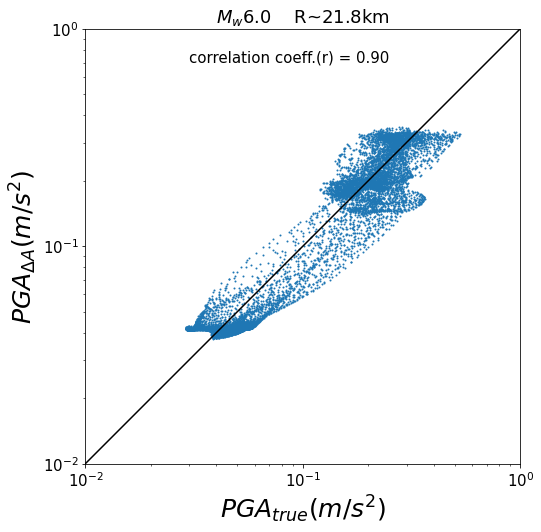

In [12]:

hypo_tmp=np.zeros((10000))
IMFilename_nc='C:/Users/s2122917/Documents/CUBIT_SPEED/GMS_basin/Karim_work/nc_PGA_new/sim_IM'+str(event_index)+'.nc'
df_tmp=xr.open_dataset(IMFilename_nc)
df_tmp.close()
df=df_tmp.to_dataframe()
pgasimul=np.array(df.pgaz[:10000])
dist=np.sqrt((np.array(df.x[:10000])-(hypo_tmp+np.array(hypo_all.x)[event_index]))**2  +  (np.array(df.y[:10000])-(hypo_tmp+np.array(hypo_all.y)[event_index]))**2)
fig=plt.figure(figsize=(8,8))
if event_index<20:
    meanfield=gmpe(dist,*popt_m6)
    pgacalc=np.exp(np.log(meanfield)+aj[event_index])
    plt.scatter(pgasimul,pgacalc,s=1,label='Mw6ev'+str(event_index+1))
    plt.title(r'$M_{w}6.0$    R~'+str(np.round(np.mean(dist)/1000,1))+'km')

else:
    meanfield=gmpe(dist,*popt_m5)
    pgacalc=np.exp(np.log(meanfield)+aj[event_index])
    plt.scatter(pgasimul,pgacalc,s=1,label='Mw5ev'+str(event_index+1-20))
    
plt.xlim([0.01,1])
plt.ylim([0.01,1])
plt.ylabel(r'$PGA_{\Delta A} (m/s^{2})$',fontsize=25)
plt.xlabel(r'$PGA_{true} (m/s^2)$',fontsize=25)
plt.plot([0,5.75],[0,5.75],c='black')
plt.xscale('log')
plt.yscale('log')
ax=plt.gca()
ax.set_aspect('equal')
cof=np.corrcoef(pgacalc,pgasimul)[0,1]
plt.text(0.03,0.7,"correlation coeff.(r) = %.2f "%cof)
plt.show()

<a name='easyload'/> </a>
### Plotting the correlation results ($PGA_{\Delta A}$) for all the events using the procedure described above

Here we load the dataset of $PGA_{\Delta A}$ (pre-calculated using above procedure) and $PGA_{true}$ (PGA values resulting out of simulations)

In [13]:
## Load the pga_deltaA and pga_true values 
pgcal=np.loadtxt('Data/pgzcal.txt')
pgsim=np.loadtxt('Data/pgzsim.txt')

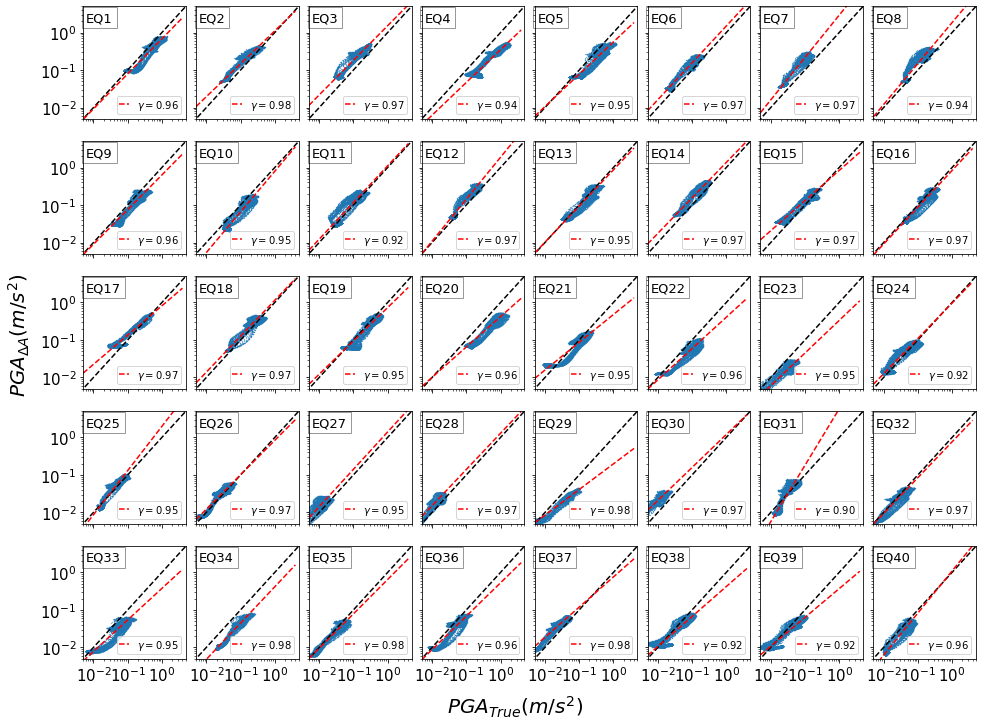

In [14]:

# Create a figure and an array of subplots
fig, axes = plt.subplots(5, 8, figsize=(16, 12),sharex=True,sharey=True)
plt.rc('font',size=13)
corr_cf=np.zeros(40)
epi=np.zeros(40)
# Loop through each subplot
for i, ax in enumerate(axes.flat):
    m, b = np.polyfit(np.log10(pgsim[i]), np.log10(pgcal[i]), 1)
    xreg=np.arange(0.005,5)
    yreg=((xreg)**(m))*10**b
    cof=np.corrcoef(np.log10(pgcal[i]),np.log10(pgsim[i]))[0,1]
    corr_cf[i]=cof
    ax.scatter(pgsim[i], pgcal[i],s=0.05)
    ax.plot([0,5.75],[0,5.75],c='black',linestyle='dashed')
    ax.plot(xreg,yreg,c='red',linestyle='dashed',label=r'$\gamma= %.2f$'%cof)

    ax.set_xlim([0.005,5])
    ax.set_ylim([0.005,5])
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.legend(loc='lower right',fontsize=10,handlelength=1.,borderpad=0.2)
    ax.set_xticks([0.01,0.1,1])
    ax.set_yticks([0.01,0.1,1])
    dist=np.sqrt((df.x[5000]-hypo_all.x[i])**2  +  (df.y[5000]-hypo_all.y[i])**2)
    epi[i]=dist
    ax.text(0.006,2,r'EQ'+str(i+1),bbox=dict(facecolor='none',edgecolor='black',alpha=0.4))

plt.subplots_adjust(hspace=0.2,wspace=0.1)
fig.text(0.5, 0.07, r'$PGA_{True} (m/s^{2})$', ha='center', va='center', fontsize=20)
fig.text(0.07, 0.5, r'$PGA_{\Delta A} (m/s^{2})$', ha='center', va='center', rotation='vertical', fontsize=20)
plt.show()
